<a href="https://colab.research.google.com/github/Higgins2718/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [14]:
bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'


weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, infer_datetime_format=True)

weather.head()

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,WSF2,WSF5,FMTM,WT14,WT01,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,89,112,-9999,1,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,130,179,-9999,-9999,1,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,54,67,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,203,0,0,122,56,47,180,190,107,148,-9999,-9999,1,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,13,0,0,89,28,61,200,220,107,165,-9999,-9999,1,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999


In [16]:
weather.columns

Index(['STATION', 'STATION_NAME', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN',
       'AWND', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'FMTM', 'WT14', 'WT01', 'WT17',
       'WT05', 'WT02', 'WT22', 'WT04', 'WT13', 'WT16', 'WT08', 'WT18', 'WT03'],
      dtype='object')

In [0]:
# TODO 
# Feature Importances
# Permutation Importances
# Partial Dependence Plot
# Shapley Values
from sklearn.model_selection import train_test_split
weather = weather.drop(columns='STATION')
weather = weather.drop(columns='STATION_NAME')

y = weather['TMAX']
X = weather.drop(columns='TMAX')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, test_size=0.20, random_state=42)

In [21]:
!pip install category_encoders

     |████████████████████████████████| 92kB 5.9MB/s 


In [37]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)


param_distributions = {
}
# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=LogisticRegression(solver='lbfgs'), 
    param_distributions = param_distributions,
    n_iter=2, 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=2. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureW

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={}, pre_dispatch='2*n_jobs', random_state=42,
          refit=True, return_train_score=True, scoring=None, verbose=10)

In [40]:
print('Score:', search.best_score_)

Score: 0.05037313432835821


In [41]:
n = len(X_train.columns)
figsize = (5,15)
best = search.best_estimator_

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=figsize)
top_n.plot.barh(color='gray');

AttributeError: ignored

Why doesn't this work?

In [43]:
!pip install eli5

     |████████████████████████████████| 102kB 4.7MB/s 


In [46]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best)

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
           n_iter=5, random_state=None, refit=True, scoring=None)

In [48]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 41.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


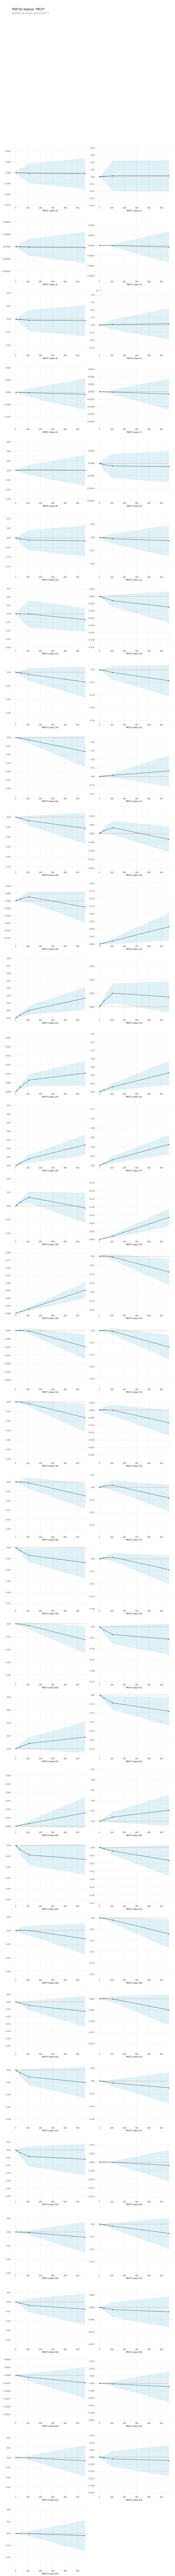

In [50]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'PRCP'

isolated = pdp_isolate(
    model=best, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [52]:
X_test = encoder.transform(X_test)
y_pred_proba = best.predict_proba(X_test.values)[:,1]

threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)
confidence = np.abs(y_pred_proba - threshold)
preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 
                      'y_pred_proba': y_pred_proba, 
                      'confidence': confidence})

preds.head(50)

,y_test,y_pred,y_pred_proba,confidence
DATE,,,,
2013-01-29,83,0,1.678355e-16,0.5
2014-05-31,233,0,6.175556e-15,0.5
2012-12-24,56,0,2.622999e-18,0.5
2013-01-02,61,0,5.410747e-15,0.5
2012-09-16,244,0,4.622217e-15,0.5
2014-05-24,183,0,5.685420e-15,0.5
2015-04-18,189,0,4.625712e-15,0.5
2015-05-06,167,0,1.112028e-18,0.5
2014-06-19,256,0,4.856661e-15,0.5
